In [1]:
import numpy as np
from scipy.stats import percentileofscore
import itolapi
from itolapi import Itol
import os
from pathlib import Path
import sys

import pandas as pd
import toytree       # a tree plotting library
import toyplot       # a general plotting library
import numpy as np   # numerical library
import os
from Bio import SeqIO
from Bio import Entrez
import subprocess
import toyplot.png
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import subprocess
import multiprocessing as mp
import ast
from Bio.Data import CodonTable

from Bio.Seq import Seq
from Bio.SeqUtils import seq3
import random
from Bio.SeqUtils import GC123
from collections import Counter

/n/home11/rkapoor/.conda/envs/rishabh/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Diamond blastp

In [2]:
dfc=pd.read_csv("revised_cluster_info_v3.csv",index_col=0)


genes=set(dfc.index)
genomes=set(dfc.genome)

In [3]:
import ast

In [3]:
hgt_intervals=[]
meta_intervals=[]
for index, row in dfc.iterrows():
    hgt_intervals.extend(ast.literal_eval(row.HGT_intervals))
    meta_intervals.extend(ast.literal_eval(row.Meta_intervals))

In [3]:
#run diamond blastp for each interval in each genome, including building a database
for g in genomes:
    try:
        input_file = open(f"/n/holyscratch01/extavour_lab/Lab/rkapoor/ncbi_dataset/data/{g}/protein.faa")
        genome_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        subprocess.run(["sh","make_diamond_genome_db.sh",g])
        for h in hgts_2+metas_2:
            if g in h:
                f=open(f"same_genome_prot_queries/{h}.fasta","w")
                inter=ast.literal_eval(h.split("_")[-1])
                seq=str(genome_dict[h.split(";")[1]].seq)
                seq=seq[inter[0]-1:inter[1]]
                f.write(">"+h+"\n")
                f.write(seq+"\n")
                f.close()
                subprocess.run(["sh","run_diamond_query.sh",h,g])
    except:
        print(g)

diamond v2.0.15.153 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 10
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: /n/holyscratch01/extavour_lab/Lab/rkapoor/ncbi_dataset/data/GCF_019393585.1/protein.faa
Opening the database file...  [0.001s]
Loading sequences...  [0.061s]
Masking sequences...  [0.073s]
Writing sequences...  [0.019s]
Hashing sequences...  [0.004s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.001s]

Database sequences  23859
  Database letters  16270257
     Database hash  dae1e3939de3324e7e949bd7fe866a52
        Total time  0.161000s
diamond v2.0.15.153 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsea

In [40]:
#parse blast results and include information on the locus/coding gene for each protein hit
def write_same_genome(genome):
    file_path=f"/n/holyscratch01/extavour_lab/Lab/rkapoor/ncbi_dataset/data/{genome}/genomic.gff"
    column_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    dfg = pd.read_csv(file_path, sep='\t', comment='#', names=column_names)
    cdfg=dfg[dfg["type"]=="CDS"]
    cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]
    for interv in [x for x in os.listdir("same_genome_prot_results") if genome in x]:
        if interv+".tsv" not in os.listdir("same_genome_prot"):
            gene=interv.split(";")[1]
            df_hgt=pd.read_csv(f"same_genome_prot_results/{interv}",sep="\t",names="qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore".split())
            dfhgti=df_hgt.copy()
            for index, row in dfhgti.iterrows():
                sprotein=row[1]
                RNA=[x.split(";Parent=rna-")[1].split(";")[0] for x in dfg.attributes if "ID=cds-"+sprotein in x][0]
                gene_name=[x.split(";Parent=gene-")[1].split(";")[0] for x in dfg.attributes if "ID=rna-"+RNA in x][0]
                dfgene=dfg[dfg.attributes.str.contains("ID=gene-"+gene_name)]
                dfhgti.loc[index,["seqid","start","end"]]=dfgene.loc[:,["seqid","start","end"]].iloc[0,:]
                dfhgti.loc[index,"gene_name"]=gene_name
            dfhgti.to_csv(f"same_genome_prot_results/{interv}",sep="\t")
    return  

In [42]:
with mp.Pool(9) as p:
    results = p.map(write_same_genome, genomes) 

/tmp/ipykernel_2895051/176159529.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]
/tmp/ipykernel_2895051/176159529.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]
/tmp/ipykernel_2895051/176159529.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



IndexError: list index out of range

In [5]:
import os

directory = "same_genome_prot_results"  

for filename in os.listdir(directory):
    if filename.endswith(".csv.tsv"):
        new_filename = os.path.join(directory, filename.replace(".csv.tsv", ".tsv"))
        os.rename(os.path.join(directory, filename), new_filename)

## Analyze within-genome hits
find putative parents that are hits to one or the other type of interval

In [4]:

#metazoan-only hits: meta e<1e-10, no hgt <10
#hgt-only hits: hgt e<1e-10, no meta >10
#pool by locus
evalue=1e-10
hgt_onlydict={}
for interv in [x for x in os.listdir("same_genome_prot_results") if "HGT" in x and ".tsv" in x and x.split(".tsv")[0] in hgt_intervals]:

    df_hgt=pd.read_csv(f"same_genome_prot_results/{interv}",sep="\t")
    hgts_only=set(df_hgt[df_hgt["evalue"]<evalue].gene_name)
    for meta_interv in [x for x in os.listdir("same_genome_prot_results") if interv.split(";")[1] in x and "Meta" in x and ".tsv" in x]:
        df_meta=pd.read_csv(f"same_genome_prot_results/{meta_interv}",sep="\t")
        hgts_only=hgts_only-set(df_meta.gene_name)
    hgt_onlydict[interv.replace(".tsv","")]=hgts_only

meta_onlydict={}
for interv in [x for x in os.listdir("same_genome_prot_results") if "Meta" in x and ".tsv" in x and x.split(".tsv")[0] in meta_intervals]:

    df_meta=pd.read_csv(f"same_genome_prot_results/{interv}",sep="\t")
    metas_only=set(df_meta[df_meta["evalue"]<evalue].gene_name)
    for hgt_interv in [x for x in os.listdir("same_genome_prot_results") if interv.split(";")[1] in x and "HGT" in x and ".tsv" in x]:
        df_hgt=pd.read_csv(f"same_genome_prot_results/{hgt_interv}",sep="\t")
        metas_only=metas_only-set(df_hgt.gene_name)
    meta_onlydict[interv.replace(".tsv","")]=metas_only

    
    

## Tandem duplication analysis 
Infers hgt-chimeras that might have originated via tandem duplication due to proximity (in number of intervening genes or nucleotides) to isolate parents

In [110]:
def calculate_inbetween_genes(interval1,interval2,self_loc,gene_name1,gene_name2):
    #given two tuple coordinates of two loci on the scaffold/loc with accession "self_loc", returns the number of intervening genes
    start1,end1=interval1
    start2,end2=interval2
    dfi=dfgenes[dfgenes.seqid==self_loc]
    dfi=dfi[dfi.start>=min(end1,end2)]
    dfi=dfi[dfi.end<=max(start1,start2)]
    dfi=dfi[~dfi.attributes.str.contains(gene_name1+";")]
    dfi=dfi[~dfi.attributes.str.contains(gene_name2+";")]
    return dfi.shape[0]
def calculate_min_distance(interval1, interval2):
    # given loci intervals provided as tuples (start, end), returns the distance between the two loci
    start1, end1 = interval1
    start2, end2 = interval2
    
    # Calculate the cases
    if end1 < start2:
        return start2 - end1
    elif end2 < start1:
        return start1 - end2
    else:
        return 0

In [201]:
!rm -r "prot_same_genome_distance"
!mkdir "prot_same_genome_distance"

In [118]:
#create dataframes with the distance between each chimera and all blast hits
for genome in genomes:
    file_path=f"ncbi_dataset/data/{genome}/genomic.gff"
    column_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    dfg = pd.read_csv(file_path, sep='\t', comment='#', names=column_names)
    cdfg=dfg[dfg.type=="CDS"]
    cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]
    dfgenes=dfg[dfg.type=="gene"]
    genome_inters=[x for x in intervals if genome in x]
    for genome_inter in genome_inters:
        
        #obtain the protein-coding gene name and coordinates 
        inter_pro=genome_inter.split(';')[1]
        RNA=[x.split(";Parent=rna-")[1].split(";")[0] for x in dfg.attributes if "ID=cds-"+inter_pro in x][0]
        #gene name
        inter_gene_name=[x.split(";Parent=gene-")[1].split(";")[0] for x in dfg.attributes if "ID=rna-"+RNA in x][0]
        #scaffold name of the protein
        inter_gene_seqid=list(dfg[dfg.attributes.str.contains("ID=gene-"+inter_gene_name)].seqid)[0]
        
        #start,end coordinate of the gene
        inter_gene_start=list(dfg[dfg.attributes.str.contains("ID=gene-"+inter_gene_name)].start)[0]
        inter_gene_end=list(dfg[dfg.attributes.str.contains("ID=gene-"+inter_gene_name)].end)[0]

        df_hgt=pd.read_csv(f"same_genome_prot_results/{genome_inter}.tsv",sep="\t")
        df_hgt=df_hgt[df_hgt.gene_name!=inter_gene_name]
        
        #remove genes overlapping with chimeric locus from the intervening gene distance calculation 
        df_hgt["same_chromosome"]=[x==inter_gene_seqid for x in df_hgt.seqid]
        df_hgt["overlap_with_interval"] = df_hgt.apply(lambda row: max(0, min(row["end"], inter_gene_end) - max(row["start"], inter_gene_start)), axis=1)
        df_hgt=df_hgt[df_hgt["overlap_with_interval"]<15]
        
        for index, row in df_hgt.iterrows():
            if row["same_chromosome"]:
                df_hgt.loc[index,"distance"]=calculate_min_distance((inter_gene_start,inter_gene_end), (row.start,row.end))
                df_hgt.loc[index,"gene_distance"]=calculate_inbetween_genes((inter_gene_start,inter_gene_end), (row.start,row.end),inter_gene_seqid, inter_gene_name,row.gene_name)
        df_hgt.loc[df_hgt.groupby("gene_name")["evalue"].idxmin()].to_csv(f"prot_same_genome_distance/{genome_inter}")



NameError: name 'genome_uniques' is not defined

In [6]:
 #creates a dataframe with hit data for all intervals at e=1e-10
f=open("gene_names.txt","r").readlines()
gene_map={x.split("--")[0]:x.split("--")[1].strip() for x in f}
inter_df=pd.DataFrame(index=[x for x in os.listdir("prot_same_genome_distance") if ";" in x and ((x in meta_intervals) or (x in hgt_intervals))])
for x in set([x for x in os.listdir("prot_same_genome_distance") if ";" in x and ((x in meta_intervals) or (x in hgt_intervals))]):

    df=pd.read_csv(f"prot_same_genome_distance/{x}")
    if "Meta" in x:
        df=df[df.gene_name.isin(meta_onlydict[x])]
    else:
        df=df[df.gene_name.isin(hgt_onlydict[x])]
    if df.shape[0]>0:
        inter_df.loc[x,"prot"]=x.split(";")[1]
        inter_df.loc[x,"gene_loc"]=gene_map[x.split(";")[1]]
        inter_df.loc[x,"annot"]=x.split(";")[-1].split("_")[0]
        inter_df.loc[x,"prot_name"]=str([(x,y) for x,y in zip(df["sseqid"],df["gene_name"])])
        inter_df.loc[x,"min_eval"]=min(df["evalue"])
        inter_df.loc[x,"n_hits"]=df.shape[0]
        inter_df.loc[x,"n_same_chromosome"]=df[df.same_chromosome==True].shape[0]
        inter_df.loc[x,"min_eval"]=min(df["evalue"])
        inter_df.loc[x,"min_eval_loc"]=str(df.loc[df["evalue"].idxmin(),"gene_name"])
        inter_df.loc[x,"min_eval_gene"]=str(df.loc[df["evalue"].idxmin(),"sseqid"])
        inter_df.loc[x,'min_eval_gene_coordinates']=str((df.loc[df["evalue"].idxmin(),:].sstart,df.loc[df["evalue"].idxmin(),:].send))
        if df[df.same_chromosome==True].shape[0]>0:
            inter_df.loc[x,"min_distance"]=min(df[df.same_chromosome==True]["distance"])
            inter_df.loc[x,"min_distance_loc"]=str(df.loc[df["distance"].idxmin(),"gene_name"])
            inter_df.loc[x,"min_distance_eval"]=str(df.loc[df["distance"].idxmin(),"evalue"])
            inter_df.loc[x,"min_gene_distance"]=min(df[df.same_chromosome==True]["gene_distance"])
            inter_df.loc[x,"min_gene_distance_loc"]=str(df.loc[df["gene_distance"].idxmin(),"gene_name"])
            inter_df.loc[x,"min_gene_distance_gene"]=str(df.loc[df["gene_distance"].idxmin(),"sseqid"])
            inter_df.loc[x,"min_gene_distance_eval"]=str(df.loc[df["gene_distance"].idxmin(),"evalue"])

inter_df=inter_df[inter_df.prot.astype(str)!='nan']


In [7]:
samec=inter_df[inter_df.n_same_chromosome>0]

In [8]:
less_than2=samec[samec.min_gene_distance<=2]


In [9]:
less_than2.shape[0]

14

In [10]:
len(set(less_than2.prot))

13

## Retrotransposition
Determine retrotransposition candidates: 1. intervals not found on the same chromosome/scaffold as their parents; 2.spanned by 0 introns in the chimera and >=1 intron in the parent

In [11]:
def get_exon_boundaries(n):
    #return a list of touples containing demarcating the protein into exons 
    genome=n.split(";")[0]
    file_path=f"ncbi_dataset/data/{genome}/genomic.gff"
    column_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    dfg = pd.read_csv(file_path, sep='\t', comment='#', names=column_names)
    gene=n.split(";")[1]
    rna=[x.split("Parent=rna-")[1].split(";")[0] for x in dfg[dfg.attributes.str.contains(f"protein_id={gene}")].attributes]
    rna=rna[0]
    gene_df=dfg[dfg.attributes.str.contains(rna)]
 
    cdsg=gene_df[gene_df.type=="CDS"]
    cdsg=cdsg.sort_values("start")
    if cdsg.strand.values[0]=='-':
        cdsg=cdsg.sort_values('start',ascending=False)
    aas=[0]
    for index, row in cdsg.iterrows():
        aas.append((row.end-row.start+1)/3+aas[-1])
    aas[-1]=aas[-1]-1
    return aas

In [12]:
def calculate_overlap_percentage(intervals, q):
    #for a list of interval touples (intervals), calculate the percentage overlap of each with the interval q
    def get_overlap_percentage(interval1, interval2):
        # Calculate the intersection (overlap) between two intervals
        intersection_start = max(interval1[0], interval2[0])
        intersection_end = min(interval1[1], interval2[1])

        # Calculate the length of the intersection
        intersection_length = max(0, intersection_end - intersection_start)

        # Calculate the length of the query interval
        q_length = q[1] - q[0]

        # Calculate the percentage of overlap between the intervals
        overlap_percentage = (intersection_length / q_length) * 100

        return overlap_percentage

    overlap_percentages = {}
    for interval in intervals:
        overlap_percentage = get_overlap_percentage(interval, q)
        overlap_percentages[interval]=(overlap_percentage)

    return overlap_percentages


In [13]:
inter_overlaps={}
all_intervals=hgt_intervals+meta_intervals
genome_gene=set([";".join(x.split(";")[0:2]) for x in all_intervals])
for g in genome_gene:
    c={}
    b=get_exon_boundaries(g)
    inters=[(b[i],b[i+1]) for i in range(len(b)-1)]
    td=[x for x in all_intervals if g in x]
    for gi in td:
        inter_overlaps[gi]=calculate_overlap_percentage(inters, ast.literal_eval(gi.split("_")[-1]))
for index,row in inter_df.iterrows():
    n_exons=len([x for x in inter_overlaps[index] if inter_overlaps[index][x] >0])
    inter_df.loc[index,"n_exons"]=n_exons

In [20]:
for n,row in inter_df.iterrows():
    if n=='GCF_002217175.1;XP_035708168.1;Meta_(13,120)':
        df=pd.read_csv(f"same_genome_prot_results/{n}.tsv",sep="\t")

        par=row["min_eval_gene"]
        parstart=ast.literal_eval(row['min_eval_gene_coordinates'])[0]
        parend=ast.literal_eval(row['min_eval_gene_coordinates'])[1]

        b=get_exon_boundaries(n.split(";")[0]+";"+par)
        inters=[(b[i],b[i+1]) for i in range(len(b)-1)]
        q=(parstart,parend)

        overlaps=calculate_overlap_percentage(inters,q)
        n_exons=len([x for x in overlaps if overlaps[x]>0])

        inter_df.loc[n,"parent_n_exons"]=n_exons
        break

In [16]:
inter_df['retro']=(inter_df.n_exons==1)&(inter_df.parent_n_exons>1)
inter_df['tandem']=inter_df.min_gene_distance<=2

In [ ]:
df=pd.read_csv(f"same_genome_prot_results/{n}.tsv",sep="\t")
par=row["min_eval_gene"]
parstart=ast.literal_eval(row['min_eval_gene_coordinates'])[0]
parend=ast.literal_eval(row['min_eval_gene_coordinates'])[1]

b=get_exon_boundaries(n.split(";")[0]+";"+par)
inters=[(b[i],b[i+1]) for i in range(len(b)-1)]
q=(parstart,parend)

overlaps=calculate_overlap_percentage(inters,q)

In [26]:
inter_df['min_eval_gene_coordinates']=["'"+x+"'" for x in inter_df['min_eval_gene_coordinates']]
inter_df['interval']=["'"+x.split("_")[-1]+"'" for x in inter_df.index]

In [29]:
inter_df.loc[:,['prot','interval','annot', 'gene_loc', 'prot_name', 'min_eval', 'n_hits',
       'n_same_chromosome', 'min_eval_loc', 'min_eval_gene',
       'min_eval_gene_coordinates', 'min_distance', 'min_distance_loc',
       'min_distance_eval', 'min_gene_distance', 'min_gene_distance_loc',
       'min_gene_distance_gene', 'min_gene_distance_eval', 'n_exons',
       'parent_n_exons', 'tandem','retro']].to_csv("data_upload_3_24_2025/Supplementary Table VII_ Within Genome BLAST Results - within_genome_parent_blast.tsv",sep="\t")

## Figure 4

In [34]:
df=pd.read_csv("data_upload_3_24_2025/Supplementary Table VII_ Within Genome BLAST Results - within_genome_parent_blast.tsv",sep="\t")

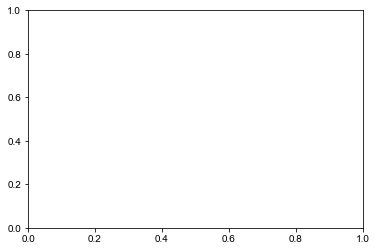

In [31]:
import os
from pathlib import Path
import sys

import pandas as pd
import numpy as np   # numerical library
import subprocess

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import subprocess
import multiprocessing as mp
import ast


sys.path.insert(0, '/net/bos-nfsisilon/ifs/rc_labs/extavour_lab/rkapoor/home_migrate')
from tax_pkg import taxid
# from tax_pkg import accession2taxid
import pandas as pd
import multiprocessing as mp
import sys
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager

from pathlib import Path

import matplotlib as mpl

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots()

fpath = Path(mpl.get_data_path(), "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")

from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
plt.rcParams['figure.dpi'] = 300
font_path = "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf"
font_manager.fontManager.addfont("/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

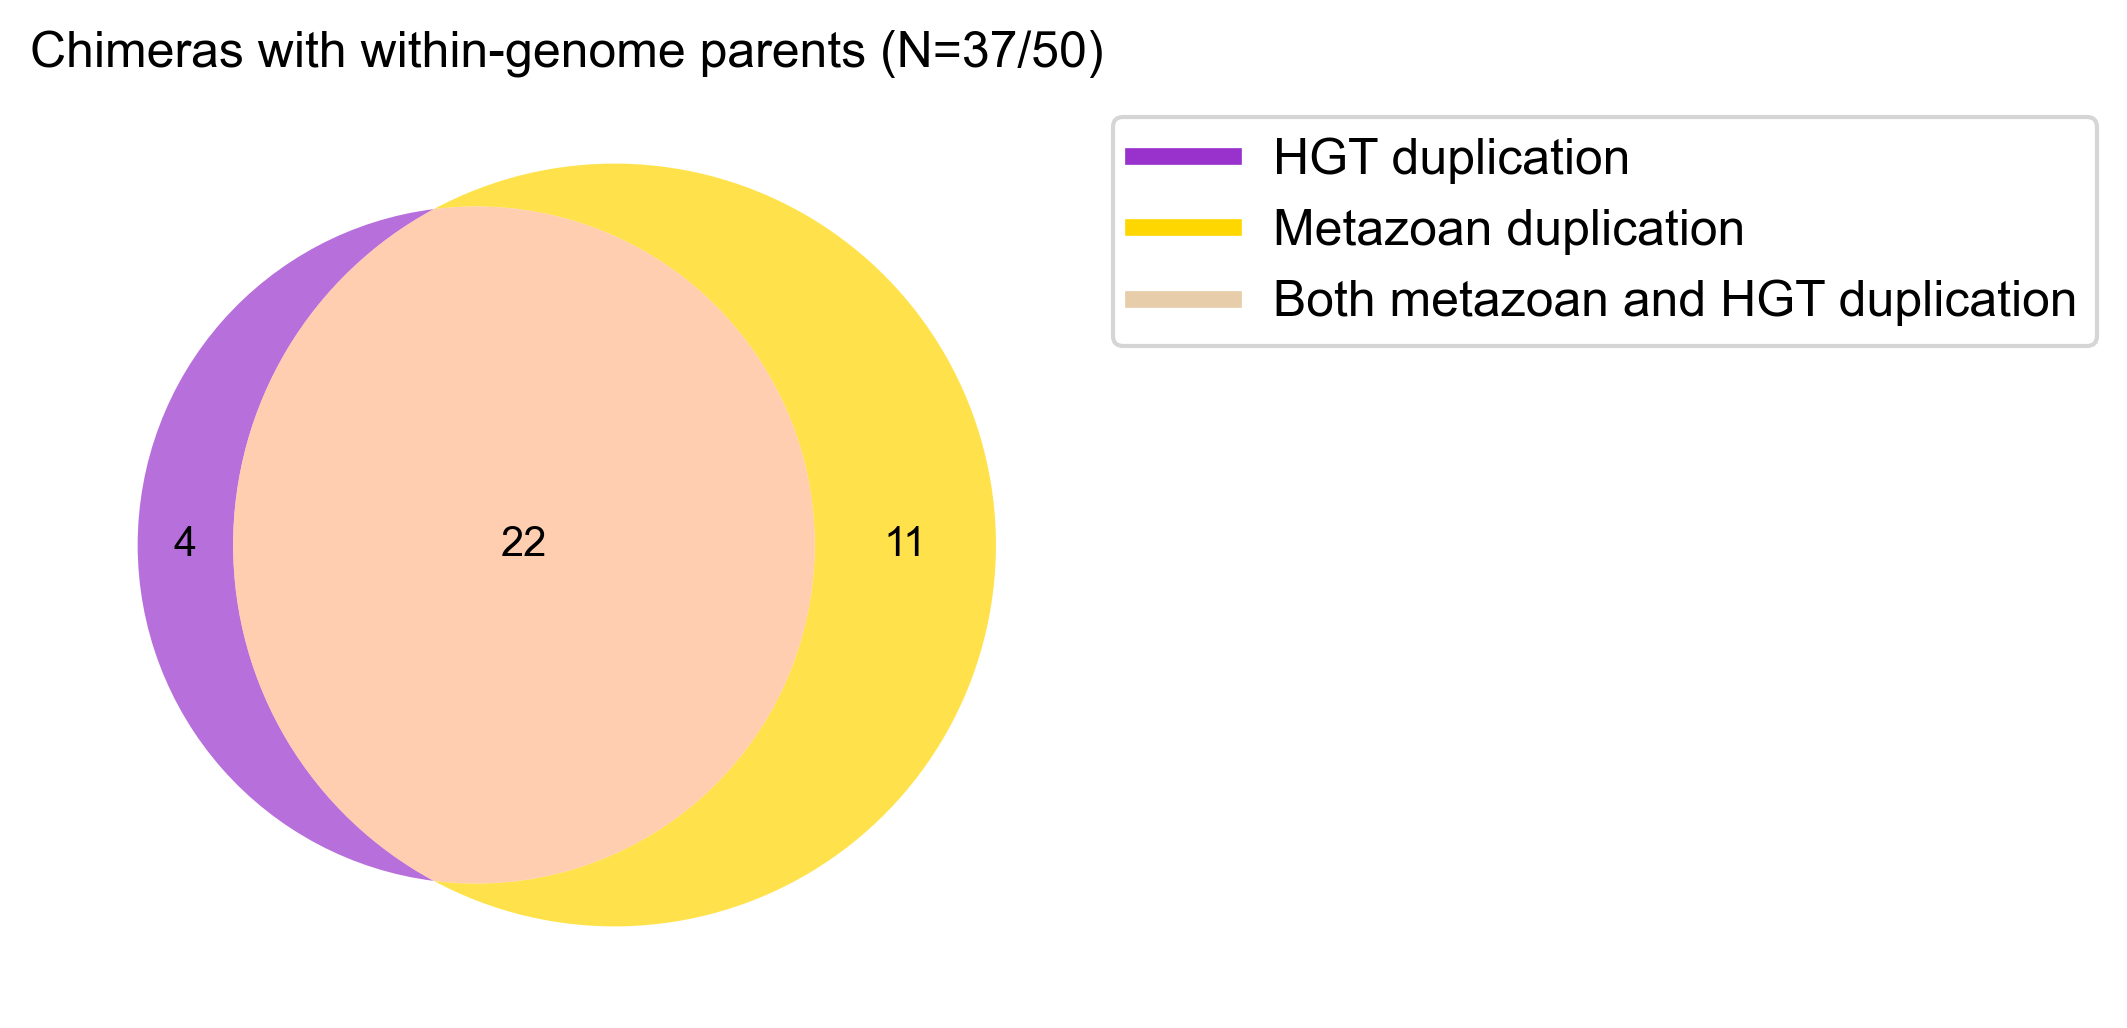

In [37]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
fig=plt.figure(dpi=300)
# Set data for the two sets
e=1e-10
# Create the figure and axes
# First Venn diagram
hgt_only = set(df[(df.annot=='HGT')].prot)
meta_only = set(df[(df.annot=='Meta')].prot)
venn2([hgt_only, meta_only], set_colors=('darkorchid', 'gold'), set_labels=['',''],alpha=0.7)


plt.title("Chimeras with within-genome parents (N=37/50)")

legend_elements = [  
Line2D([0], [0], color='darkorchid', lw=4, label='HGT duplication'),
Line2D([0], [0], color='gold', lw=4, label='Metazoan duplication'),
Line2D([0], [0], color='burlywood', lw=4, alpha=.7,label='Both metazoan and HGT duplication')
    
]

custom_font = FontProperties(fname="/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf", size=12)
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.02, 1),prop=custom_font)
plt.savefig('parent_venn_all_chimeras.svg',format='svg', bbox_inches="tight")
plt.show()

In [38]:
inter_df[inter_df.min_gene_distance<=2].shape[0]

14

In [39]:
inter_df[(inter_df.n_exons==1)&(inter_df.parent_n_exons>1)].shape[0]

5

In [42]:
all_intervals=hgt_intervals+meta_intervals

In [49]:
!rm -r data_upload_3_24_2025/within_genome_blast
!mkdir data_upload_3_24_2025/within_genome_blast
for x in all_intervals:
    !cp same_genome_prot_results/"$x".tsv data_upload_3_24_2025/within_genome_blast/"$x".tsv

In [50]:
!tar -czf within_genome_blast.tar.gz -C data_upload_3_24_2025 within_genome_blast